In [1]:
#import dask.dataframe as pd
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import random
import re

PATH = '.'
print(os.listdir(f'{PATH}'))



['sample_submission.csv', 'data', 'periods_test.csv', 'periods_train.csv', 'test_active.csv', 'test.csv', 'train_active.csv', '.ipynb_checkpoints', '.git', 'ru.bin', 'ru.vec', 'dask-worker-space', 'data.h5', 'tr_desc_pad.pk', 'tr_desc.npy', 'cc.ru.300.bin', 'desc_vectors.npz', 'tr_desc.npz', 'test_ru.txt', 'best-use_pretrainedTrue-use_imagesTrue-finetune_pretrainedFalse-val0.22229', 'best-use_pretrainedTrue-use_imagesFalse-finetune_pretrainedFalse-val0.22126.hdf5', 'best-use_pretrainedTrue-use_imagesFalse-finetune_pretrainedTrue.hdf5', 'train-ft-images-wolf.ipynb', 'best-use_pretrainedTrue-use_imagesTrue-finetune_pretrainedTrue.hdf5', 'best-use_pretrainedTrue-use_imagesFalse-finetune_pretrainedFalse.hdf5', 'df_x_train', 'df_y_train', 'df_test', 'best-a.use_pretrainedTrue-a.use_imagesFalse-a.finetune_pretrainedFalse.hdf5', 'best-use_pretrainedTrue-use_imagesTrue-finetune_pretrainedFalse.hdf5', 'multi_gpu_keras.py', '__pycache__', 'image_top_1.csv', 'train_images.py', 'extra', 'clr_callb

In [2]:
use_pretrained = True
use_images     = False
finetune_pretrained = True

In [3]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_test  = pd.read_csv(f'{PATH}/test.csv')

df_train_active = pd.read_csv(f'{PATH}/train_active.csv', usecols=['item_id', 'user_id'])
df_test_active  = pd.read_csv(f'{PATH}/test_active.csv',  usecols=['item_id', 'user_id'])

df_train_periods = pd.read_csv(f'{PATH}/periods_train.csv', parse_dates=['date_from', 'date_to'])
df_test_periods  = pd.read_csv(f'{PATH}/periods_test.csv',  parse_dates=['date_from', 'date_to'])


In [4]:
city_region_unique = pd.read_csv("avito_region_city_features.csv")


In [5]:
df_train.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å      –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥   
1  2dac0150717d  39aeb48f0017      –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å            –°–∞–º–∞—Ä–∞   
2  ba83aefab5dc  91e2f88dd6e3     –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å    –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É   
3  02996f1dd2ea  bf5cccea572d              –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  –ù–∞–±–µ—Ä–µ–∂–Ω—ã–µ –ß–µ–ª–Ω—ã   
4  7c90be56d2ab  ef50846afc0b  –í–æ–ª–≥–æ–≥—Ä–∞–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å         –í–æ–ª–≥–æ–≥—Ä–∞–¥   

  parent_category_name               category_name  \
0          –õ–∏—á–Ω—ã–µ –≤–µ—â–∏  –¢–æ–≤–∞—Ä—ã –¥–ª—è –¥–µ—Ç–µ–π –∏ –∏–≥—Ä—É—à–∫–∏   
1      –î–ª—è –¥–æ–º–∞ –∏ –¥–∞—á–∏           –ú–µ–±–µ–ª—å –∏ –∏–Ω—Ç–µ—Ä—å–µ—Ä   
2  –ë—ã—Ç–æ–≤–∞—è —ç–ª–µ–∫—Ç—Ä–æ–Ω–∏–∫–∞               –ê—É–¥–∏–æ –∏ –≤–∏–¥–µ–æ   
3          –õ–∏—á–Ω—ã–µ –≤–µ—â–∏  –¢–æ–≤–∞—Ä—ã –¥–ª—è –¥–µ—Ç–µ–π –∏ –∏–≥—Ä—É—à–∫–∏   
4            –¢—Ä–∞–Ω—Å–ø–æ—Ä—Ç                  –ê–≤—Ç–æ–º–æ–±–∏–ª–∏   

                       param_1     param_2 param_3                  title  \
0    –ü–æ—Å—Ç–µ–ª—å–Ω—ã–µ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏         NaN     NaN  –ö–æ–∫–æ–±–∏(–∫–æ–∫–æ–Ω –¥–ª—è —Å–Ω–∞)   
1                       –î—Ä—É–≥–æ–µ         NaN     NaN      –°—Ç–æ–π–∫–∞ –¥–ª—è –û–¥–µ–∂–¥—ã   
2  –í–∏–¥–µ–æ, DVD –∏ Blu-ray –ø–ª–µ–µ—Ä—ã         NaN     NaN         Philips bluray   
3         –ê–≤—Ç–æ–º–æ–±–∏–ª—å–Ω—ã–µ –∫—Ä–µ—Å–ª–∞         NaN     NaN             –ê–≤—Ç–æ–∫—Ä–µ—Å–ª–æ   
4                   –° –ø—Ä–æ–±–µ–≥–æ–º  –í–ê–ó (LADA)    2110         –í–ê–ó 2110, 2003   

                                         description    price  \
0  –ö–æ–∫–æ–Ω –¥–ª—è —Å–Ω–∞ –º–∞–ª—ã—à–∞,–ø–æ–ª—å–∑–æ–≤–∞–ª–∏—Å—å –º–µ–Ω—å—à–µ –º–µ—Å—è—Ü...    400.0   
1          –°—Ç–æ–π–∫–∞ –¥–ª—è –æ–¥–µ–∂–¥—ã, –ø–æ–¥ –≤–µ—à–∞–ª–∫–∏. –° –±—É—Ç–∏–∫–∞.   3000.0   
2  –í —Ö–æ—Ä–æ—à–µ–º —Å–æ—Å—Ç–æ—è–Ω–∏–∏, –¥–æ–º–∞—à–Ω–∏–π –∫–∏–Ω–æ—Ç–µ–∞—Ç—Ä —Å blu ...   4000.0   
3                             –ü—Ä–æ–¥–∞–º –∫—Ä–µ—Å–ª–æ –æ—Ç0-25–∫–≥   2200.0   
4                           –í—Å–µ –≤–æ–ø—Ä–æ—Å—ã –ø–æ —Ç–µ–ª–µ—Ñ–æ–Ω—É.  40000.0   

   item_seq_number activation_date user_type  \
0                2      2017-03-28   Private   
1               19      2017-03-26   Private   
2                9      2017-03-20   Private   
3              286      2017-03-25   Company   
4                3      2017-03-16   Private   

                                               image  image_top_1  \
0  d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...       1008.0   
1  79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...        692.0   
2  b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...       3032.0   
3  e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...        796.0   
4  54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...       2264.0   

   deal_probability  
0           0.12789  
1           0.00000  
2           0.43177  
3           0.80323  
4           0.20797

In [6]:
city_region_unique.head()

region              city                        city_region  \
0   –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å      –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥  –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥ –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
1      –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å            –°–∞–º–∞—Ä–∞           –°–∞–º–∞—Ä–∞ –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
2     –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å    –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É  –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
3              –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  –ù–∞–±–µ—Ä–µ–∂–Ω—ã–µ –ß–µ–ª–Ω—ã         –ù–∞–±–µ—Ä–µ–∂–Ω—ã–µ –ß–µ–ª–Ω—ã –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω   
4  –í–æ–ª–≥–æ–≥—Ä–∞–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å         –í–æ–ª–≥–æ–≥—Ä–∞–¥    –í–æ–ª–≥–æ–≥—Ä–∞–¥ –í–æ–ª–≥–æ–≥—Ä–∞–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   

    latitude  longitude  lat_lon_hdbscan_cluster_05_03  \
0  56.838926  60.605702                             65   
1  53.241504  50.221246                             58   
2  47.235714  39.701505                             46   
3  55.718505  52.372104                             55   
4  48.708048  44.513303                             31   

   lat_lon_hdbscan_cluster_10_03  lat_lon_hdbscan_cluster_20_03  region_id  \
0                             38                             21         19   
1                             36                             19         17   
2                             40                              9         16   
3                             33                             18         21   
4                             17                             -1          4   

   city_region_id  
0             477  
1            1370  
2            1346  
3             982  
4             327

In [7]:
df_train = pd.merge(left=df_train, right=city_region_unique, how="left", on=["region", "city"])
df_test = pd.merge(left=df_test, right=city_region_unique, how="left", on=["region", "city"])


In [8]:
df_train.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å      –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥   
1  2dac0150717d  39aeb48f0017      –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å            –°–∞–º–∞—Ä–∞   
2  ba83aefab5dc  91e2f88dd6e3     –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å    –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É   
3  02996f1dd2ea  bf5cccea572d              –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  –ù–∞–±–µ—Ä–µ–∂–Ω—ã–µ –ß–µ–ª–Ω—ã   
4  7c90be56d2ab  ef50846afc0b  –í–æ–ª–≥–æ–≥—Ä–∞–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å         –í–æ–ª–≥–æ–≥—Ä–∞–¥   

  parent_category_name               category_name  \
0          –õ–∏—á–Ω—ã–µ –≤–µ—â–∏  –¢–æ–≤–∞—Ä—ã –¥–ª—è –¥–µ—Ç–µ–π –∏ –∏–≥—Ä—É—à–∫–∏   
1      –î–ª—è –¥–æ–º–∞ –∏ –¥–∞—á–∏           –ú–µ–±–µ–ª—å –∏ –∏–Ω—Ç–µ—Ä—å–µ—Ä   
2  –ë—ã—Ç–æ–≤–∞—è —ç–ª–µ–∫—Ç—Ä–æ–Ω–∏–∫–∞               –ê—É–¥–∏–æ –∏ –≤–∏–¥–µ–æ   
3          –õ–∏—á–Ω—ã–µ –≤–µ—â–∏  –¢–æ–≤–∞—Ä—ã –¥–ª—è –¥–µ—Ç–µ–π –∏ –∏–≥—Ä—É—à–∫–∏   
4            –¢—Ä–∞–Ω—Å–ø–æ—Ä—Ç                  –ê–≤—Ç–æ–º–æ–±–∏–ª–∏   

                       param_1     param_2 param_3                  title  \
0    –ü–æ—Å—Ç–µ–ª—å–Ω—ã–µ –ø—Ä–∏–Ω–∞–¥–ª–µ–∂–Ω–æ—Å—Ç–∏         NaN     NaN  –ö–æ–∫–æ–±–∏(–∫–æ–∫–æ–Ω –¥–ª—è —Å–Ω–∞)   
1                       –î—Ä—É–≥–æ–µ         NaN     NaN      –°—Ç–æ–π–∫–∞ –¥–ª—è –û–¥–µ–∂–¥—ã   
2  –í–∏–¥–µ–æ, DVD –∏ Blu-ray –ø–ª–µ–µ—Ä—ã         NaN     NaN         Philips bluray   
3         –ê–≤—Ç–æ–º–æ–±–∏–ª—å–Ω—ã–µ –∫—Ä–µ—Å–ª–∞         NaN     NaN             –ê–≤—Ç–æ–∫—Ä–µ—Å–ª–æ   
4                   –° –ø—Ä–æ–±–µ–≥–æ–º  –í–ê–ó (LADA)    2110         –í–ê–ó 2110, 2003   

        ...       image_top_1  deal_probability  \
0       ...            1008.0           0.12789   
1       ...             692.0           0.00000   
2       ...            3032.0           0.43177   
3       ...             796.0           0.80323   
4       ...            2264.0           0.20797   

                         city_region   latitude  longitude  \
0  –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥ –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å  56.838926  60.605702   
1           –°–∞–º–∞—Ä–∞ –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å  53.241504  50.221246   
2  –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å  47.235714  39.701505   
3         –ù–∞–±–µ—Ä–µ–∂–Ω—ã–µ –ß–µ–ª–Ω—ã –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  55.718505  52.372104   
4    –í–æ–ª–≥–æ–≥—Ä–∞–¥ –í–æ–ª–≥–æ–≥—Ä–∞–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å  48.708048  44.513303   

  lat_lon_hdbscan_cluster_05_03  lat_lon_hdbscan_cluster_10_03  \
0                            65                             38   
1                            58                             36   
2                            46                             40   
3                            55                             33   
4                            31                             17   

   lat_lon_hdbscan_cluster_20_03 region_id  city_region_id  
0                             21        19             477  
1                             19        17            1370  
2                              9        16            1346  
3                             18        21             982  
4                             -1         4             327  

[5 rows x 26 columns]

In [9]:
all_samples = pd.concat([
    df_train[['item_id', 'user_id']],
    df_train_active,
    df_test[['item_id', 'user_id']],
    df_test_active
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True)


In [10]:
all_periods = pd.concat([
    df_train_periods,
    df_test_periods
])

all_periods.head()

item_id activation_date  date_from    date_to
0  8f5caef7afb0      2017-02-14 2017-03-15 2017-03-16
1  66218ff526d1      2017-02-16 2017-03-15 2017-03-18
2  b237d9539b21      2017-03-01 2017-03-15 2017-03-28
3  80bf58082ad3      2017-03-19 2017-03-19 2017-03-28
4  67a9944a7373      2017-03-14 2017-03-15 2017-03-28

In [11]:
all_periods['days_up'] = all_periods['date_to'].dt.dayofyear - all_periods['date_from'].dt.dayofyear

In [12]:
gp = all_periods.groupby(['item_id'])[['days_up']]

gp_df = pd.DataFrame()
gp_df['days_up_sum']  = gp.sum()['days_up']
gp_df['times_put_up'] = gp.count()['days_up']
gp_df.reset_index(inplace=True)
gp_df.rename(index=str, columns={'index': 'item_id'})

gp_df.head()

item_id  days_up_sum  times_put_up
0  00000077ff21           13             1
1  000002c54018            6             1
2  000005570503            1             1
3  0000060018e6            6             1
4  000006497719           19             2

In [13]:
all_periods.drop_duplicates(['item_id'], inplace=True)
all_periods = all_periods.merge(gp_df, on='item_id', how='left')
all_periods.head()

item_id activation_date  date_from    date_to  days_up  days_up_sum  \
0  8f5caef7afb0      2017-02-14 2017-03-15 2017-03-16        1           17   
1  66218ff526d1      2017-02-16 2017-03-15 2017-03-18        3           18   
2  b237d9539b21      2017-03-01 2017-03-15 2017-03-28       13           19   
3  80bf58082ad3      2017-03-19 2017-03-19 2017-03-28        9           17   
4  67a9944a7373      2017-03-14 2017-03-15 2017-03-28       13           18   

   times_put_up  
0             4  
1             3  
2             2  
3             4  
4             3

In [14]:
all_periods = all_periods.merge(all_samples, on='item_id', how='left')
all_periods.head()

item_id activation_date  date_from    date_to  days_up  days_up_sum  \
0  8f5caef7afb0      2017-02-14 2017-03-15 2017-03-16        1           17   
1  66218ff526d1      2017-02-16 2017-03-15 2017-03-18        3           18   
2  b237d9539b21      2017-03-01 2017-03-15 2017-03-28       13           19   
3  80bf58082ad3      2017-03-19 2017-03-19 2017-03-28        9           17   
4  67a9944a7373      2017-03-14 2017-03-15 2017-03-28       13           18   

   times_put_up       user_id  
0             4  e292cce69842  
1             3  a326c04a24ec  
2             2  06d275498a56  
3             4  831c8c4a622c  
4             3  248102e50d79

In [15]:
gp = all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].mean().reset_index() \
    .rename(index=str, columns={
        'days_up_sum' : 'avg_days_up_user',
        'times_put_up': 'avg_times_up_user'
    })

gp = gp.merge(all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].max().reset_index() \
    .rename(index=str, columns={
        'days_up_sum' : 'max_days_up_user',
        'times_put_up': 'max_times_up_user'
    }), on='user_id', how='outer')

gp = gp.merge(all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].min().reset_index() \
    .rename(index=str, columns={
        'days_up_sum' : 'min_days_up_user',
        'times_put_up': 'min_times_up_user'
    }), on='user_id', how='outer')

In [16]:
gp.head()


user_id  avg_days_up_user  avg_times_up_user  max_days_up_user  \
0  00000077ff21              12.5               2.00                15   
1  000006497719              19.0               2.00                19   
2  00000b4d72f6               3.0               1.00                 3   
3  00000d642d7e              13.0               1.00                13   
4  0000126b80a4              12.0               1.75                19   

   max_times_up_user  min_days_up_user  min_times_up_user  
0                  2                10                  2  
1                  2                19                  2  
2                  1                 3                  1  
3                  1                13                  1  
4                  4                 6                  1

In [17]:
n_user_items = all_samples.groupby(['user_id'])[['item_id']].count().reset_index() \
    .rename(index=str, columns={
        'item_id': 'n_user_items'
    })
gp = gp.merge(n_user_items, on='user_id', how='outer')

gp.head()

user_id  avg_days_up_user  avg_times_up_user  max_days_up_user  \
0  00000077ff21              12.5               2.00              15.0   
1  000006497719              19.0               2.00              19.0   
2  00000b4d72f6               3.0               1.00               3.0   
3  00000d642d7e              13.0               1.00              13.0   
4  0000126b80a4              12.0               1.75              19.0   

   max_times_up_user  min_days_up_user  min_times_up_user  n_user_items  
0                2.0              10.0                2.0             2  
1                2.0              19.0                2.0             1  
2                1.0               3.0                1.0             1  
3                1.0              13.0                1.0             2  
4                4.0               6.0                1.0             8

In [18]:
df_y_train = pd.DataFrame(df_train['deal_probability'])
df_x_train = df_train.drop(['deal_probability'], axis=1)

In [19]:
df_x_train = df_x_train.merge(gp,    on='user_id', how='left')
df_test    = df_test.merge   (gp,    on='user_id', how='left')


In [20]:
df_x_train.head(100)

item_id       user_id                 region              city  \
0   b912c3c6a6ad  e00f8ff2eaf9   –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å      –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥   
1   2dac0150717d  39aeb48f0017      –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å            –°–∞–º–∞—Ä–∞   
2   ba83aefab5dc  91e2f88dd6e3     –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å    –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É   
3   02996f1dd2ea  bf5cccea572d              –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω  –ù–∞–±–µ—Ä–µ–∂–Ω—ã–µ –ß–µ–ª–Ω—ã   
4   7c90be56d2ab  ef50846afc0b  –í–æ–ª–≥–æ–≥—Ä–∞–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å         –í–æ–ª–≥–æ–≥—Ä–∞–¥   
5   51e0962387f7  bbfad0b1ad0a              –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω         –ß–∏—Å—Ç–æ–ø–æ–ª—å   
6   c4f260a2b48a  08f469d2e6f7  –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   –ù–∏–∂–Ω–∏–π –ù–æ–≤–≥–æ—Ä–æ–¥   
7   6b71309d6a8a  fef86baa002c          –ü–µ—Ä–º—Å–∫–∏–π –∫—Ä–∞–π             –ü–µ—Ä–º—å   
8   c5b969cb63a2  055825270190   –û—Ä–µ–Ω–±—É—Ä–≥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å          –û—Ä–µ–Ω–±—É—Ä–≥   
9   b1570962e68c  f9e8f831d94c  –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   –ù–∏–∂–Ω–∏–π –ù–æ–≤–≥–æ—Ä–æ–¥   
10  d5480bb4a6e4  d46200940f37    –•–∞–Ω—Ç—ã-–ú–∞–Ω—Å–∏–π—Å–∫–∏–π –ê–û    –•–∞–Ω—Ç—ã-–ú–∞–Ω—Å–∏–π—Å–∫   
11  86f41f50d8c1  35c2b6b654e0      –¢—é–º–µ–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å      –ó–∞–≤–æ–¥–æ—É–∫–æ–≤—Å–∫   
12  645237cb3601  fc9a38b79414   –û—Ä–µ–Ω–±—É—Ä–≥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å          –û—Ä–µ–Ω–±—É—Ä–≥   
13  df2116f34563  3ce3c2318b16     –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å    –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É   
14  a97943ae8158  f643d87dd23c           –ë–∞—à–∫–æ—Ä—Ç–æ—Å—Ç–∞–Ω           –¢—É–π–º–∞–∑—ã   
15  4b6abd0a5921  94de2b374869              –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω            –ö–∞–∑–∞–Ω—å   
16  7896ef8fe482  007c6bd858cb     –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π         –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä   
17  7882b1e77748  7a3fda0cdf94  –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å       –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫   
18  071e1ed13c5c  325cacee50f4         –û–º—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å        –ú–æ—Å–∫–∞–ª–µ–Ω–∫–∏   
19  0658628930d4  27c2d83b766e   –ë–µ–ª–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å          –ë–µ–ª–≥–æ—Ä–æ–¥   
20  ea12aec32ec3  06ee4ff4e99c  –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å            –ë–µ—Ä–¥—Å–∫   
21  838a82cec0a6  5d44315f6d90   –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å      –ï–∫–∞—Ç–µ—Ä–∏–Ω–±—É—Ä–≥   
22  de310e6aae86  0178e6308f38    –ß–µ–ª—è–±–∏–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å      –ú–∞–≥–Ω–∏—Ç–æ–≥–æ—Ä—Å–∫   
23  08b24e170109  6630d724bbf5     –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å    –†–æ—Å—Ç–æ–≤-–Ω–∞-–î–æ–Ω—É   
24  065a4daba35f  19a5cd02c89b  –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   –ù–∏–∂–Ω–∏–π –ù–æ–≤–≥–æ—Ä–æ–¥   
25  990113ae4f1c  d9b494f97062    –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å           –í–æ—Ä–æ–Ω–µ–∂   
26  78164bc09657  721c2f914f63      –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å          –¢–æ–ª—å—è—Ç—Ç–∏   
27  fbe29970a8a5  2f0e2746d462    –ö–µ–º–µ—Ä–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å       –ù–æ–≤–æ–∫—É–∑–Ω–µ—Ü–∫   
28  71d9399b59a2  965ee1e259eb    –°–∞—Ä–∞—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å           –°–∞—Ä–∞—Ç–æ–≤   
29  4941f0385575  d283308a713b  –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   –ù–∏–∂–Ω–∏–π –ù–æ–≤–≥–æ—Ä–æ–¥   
..           ...           ...                    ...               ...   
70  120b06793d93  b117d660c9b7      –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å            –°–∞–º–∞—Ä–∞   
71  88b2838cc050  81885dc305dc              –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω        –ù–∏–∂–Ω–µ–∫–∞–º—Å–∫   
72  4b7ce4918084  37e85b856043              –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω            –ö–∞–∑–∞–Ω—å   
73  57d83077c16a  9e0056ae9ed3  –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   –ù–∏–∂–Ω–∏–π –ù–æ–≤–≥–æ—Ä–æ–¥   
74  1298ab2ff7f3  b94c4c860296   –í–ª–∞–¥–∏–º–∏—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å             –ú—É—Ä–æ–º   
75  083d89d7973b  091c29cc5b0f    –ß–µ–ª—è–±–∏–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å         –ß–µ–ª—è–±–∏–Ω—Å–∫   
76  6eccf4e3d546  e4233082f7bb      –¢—é–º–µ–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å            –¢—é–º–µ–Ω—å   
77  a58ad095e488  e9c83ca3716d      –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫–∏–π –∫—Ä–∞–π             –ö–∞–Ω—Å–∫   
78  8b953c3f75e8  

In [21]:
from scipy.special import erfinv 

def rank_gauss(x):
    # x is numpy vector
    N = x.shape[0]
    temp = x.argsort()
    print(temp)
    rank_x = temp.argsort() / N
    print(rank_x)
    rank_x -= rank_x.mean()
    rank_x *= 2 # rank_x.max(), rank_x.min() should be in (-1, 1)
    efi_x = erfinv(x) # np.sqrt(2)*erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

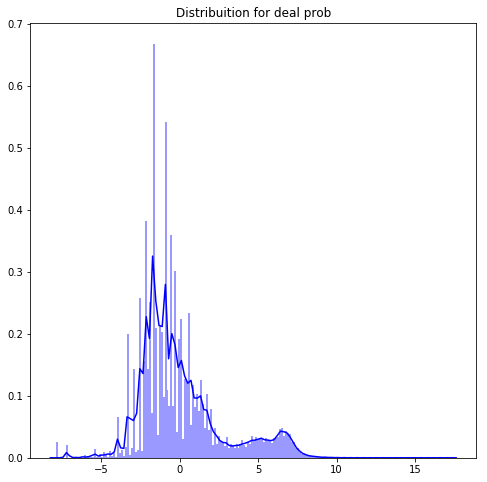

In [22]:
plt.figure(figsize = (8, 8))
plt.title('Distribuition for deal prob')
#sns.distplot(df_y_train ,color='green', kde=True,bins=200)
_price = np.log1p(df_x_train['price'].dropna().values)
_price -= _price.mean()
sns.distplot(_price ,color='blue', kde=True,bins=200)
#sns.distplot(df_x_train['avg_days_up_user'] ,color='red', kde=True,bins=200)

plt.show()

In [23]:
df_x_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1503424 entries, 0 to 1503423
Data columns (total 32 columns):
item_id                          1503424 non-null object
user_id                          1503424 non-null object
region                           1503424 non-null object
city                             1503424 non-null object
parent_category_name             1503424 non-null object
category_name                    1503424 non-null object
param_1                          1441848 non-null object
param_2                          848882 non-null object
param_3                          640859 non-null object
title                            1503424 non-null object
description                      1387148 non-null object
price                            1418062 non-null float64
item_seq_number                  1503424 non-null int64
activation_date                  1503424 non-null object
user_type                        1503424 non-null object
image                            1

In [24]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 508438 entries, 0 to 508437
Data columns (total 32 columns):
item_id                          508438 non-null object
user_id                          508438 non-null object
region                           508438 non-null object
city                             508438 non-null object
parent_category_name             508438 non-null object
category_name                    508438 non-null object
param_1                          485528 non-null object
param_2                          275209 non-null object
param_3                          202107 non-null object
title                            508438 non-null object
description                      508438 non-null object
price                            477853 non-null float64
item_seq_number                  508438 non-null int64
activation_date                  508438 non-null object
user_type                        508438 non-null object
image                            465829 non-null 

In [25]:
# viewing # of unique value in each column 
for col in df_x_train.columns:
    print(col, len(df_x_train[col].unique()))

item_id 1503424
user_id 771769
region 28
city 1733
parent_category_name 9
category_name 47
param_1 372
param_2 272
param_3 1220
title 788377
description 1317103
price 17007
item_seq_number 28232
activation_date 21
user_type 3
image 1390837
image_top_1 3063
city_region 1804
latitude 1802
longitude 1802
lat_lon_hdbscan_cluster_05_03 67
lat_lon_hdbscan_cluster_10_03 46
lat_lon_hdbscan_cluster_20_03 23
region_id 28
city_region_id 1804
avg_days_up_user 16333
avg_times_up_user 6882
max_days_up_user 21
max_times_up_user 15
min_days_up_user 21
min_times_up_user 10
n_user_items 1002


In [26]:
value = { 
    'image_top_1' : 3067,
    'image' : "NA",
    'param_1' : "NA",
    'param_2' : "NA",
    'param_3' : "NA",
    'description' : "NA",
    'title' : "NA",
    'avg_days_up_user' : -1,
    'avg_times_up_user' : -1,
    'max_days_up_user' : -1,
    'max_times_up_user' : -1,
    'min_days_up_user' : -1,
    'min_times_up_user' : -1,
    'n_user_items' : -1,
}

df_x_train = df_x_train.fillna(value=value)
df_test    = df_test.fillna(value=value)

In [27]:
#user_id_in_both = np.intersect1d(df_x_train['user_id'].values, df_test['user_id'].values) 

In [28]:
df_x_train.columns[1] 


'user_id'

In [29]:
for df in [df_x_train, df_y_train, df_test]:
    for c in df.columns:
        print(c, df[c].hasnans)
    print()


item_id False
user_id False
region False
city False
parent_category_name False
category_name False
param_1 False
param_2 False
param_3 False
title False
description False
price True
item_seq_number False
activation_date False
user_type False
image False
image_top_1 False
city_region False
latitude False
longitude False
lat_lon_hdbscan_cluster_05_03 False
lat_lon_hdbscan_cluster_10_03 False
lat_lon_hdbscan_cluster_20_03 False
region_id False
city_region_id False
avg_days_up_user False
avg_times_up_user False
max_days_up_user False
max_times_up_user False
min_days_up_user False
min_times_up_user False
n_user_items False

deal_probability False

item_id False
user_id False
region False
city False
parent_category_name False
category_name False
param_1 False
param_2 False
param_3 False
title False
description False
price True
item_seq_number False
activation_date False
user_type False
image False
image_top_1 False
city_region False
latitude False
longitude False
lat_lon_hdbscan_cluster_05_0

In [30]:
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'üò≠üìß‚ìï‚ûêüö•üïåü¶ê‚Ö∞üòú‚Äöƒ∫üì†‚öïüíÉüëéü•ö\uf8ff\u200düëæüå•üö∂üîéÀ£\uf330‚ó¶üóùüìÅüöâüç®üéΩÂíåüîÉ√£‚ô™\u2008‚ûö‚ûúÿØ…ë‚ë§\uf058‚¨Ü÷Çüìú‚óé‚óã‚â™üòáüõ†üë°üöº\uf334œÄ‚ùâüë≥üöñ√®üò§üêâüò´üòãüïäŒ≠üïô‚úΩ‚Ä£‚ôáüéø·ÉöŒº¬£\uf020üí±üì≤üíì‚öìüîã‚ùÅüò®√©üö≥üçáüîòü•á‚ú¢‚ú∫üåüü•ûüõãüê©‚ñ´üç≠ü§∑‚è´üçàüêµüë∏ü¶ã‚õ∑üòä≈õüîΩ‚û∞√´\uf381‚òÖü•ê‚ñ≤üí≠Â§ñüçïüîñüçÆüò¢‚û†’§üëâƒü‚ñåüá™‚à´üéÅüíªÃ®üêÆ‚úçüî°üê¶‚õ¥“Øü§¥‚ôêü§µüìè\u200cüåïÈßÖüíü‚úîüå∏‚öÉüåæ“õüê†‚ù∫üõÅ‚õ±üõÑü•ôü§ôü§ßüïµüî∫üëô‚òõ‚úßüíëü•óüê∫üêºüèµ å‚ùìüè¶üë∑‚áõüçÇ·¥ì‚ô≠üá≠üòê‚óíüöö‚Ä∫\u2002‚õ≤üòè‚Äªüò™‚©æüìïüïìüöóüèç‚ú≥\uf366üî•üòåüìπ∆íüö¢‚äøÀâ√∫üç¶‡©´üñçüôÉüêÉ‚Ä¶üëä≈≥üç¨‚Üì„Äã’≤‚ó¢üõÄ‚óå‚ö¶‚ñ∞’û\ufeffüò∂üòñüíÅüå≠Ãàüå§»£‚û®‚õÖüëçüõ≥‚è™œÜüîùüéüœÉüíåüç±v—ûüöÖÂ•ΩüëÑ‚ûòüñéüóø¬æüéÜ‚ùÖüó∫√≠üì∑Ëù∂üçΩ·êÉüöïÂõõüñäüíÖ‚òè‚Äïüå´üéé‚òÑüî≥‚ùóüçìüáæüì≠üëøüôãüåÆüëåüò∑üîäüôéüéÇü¶âüç¥üç¢üì©‚Öúüî∞”©‚ùß‚û¢üåâüçß‚ñ†≈à‚ñπ\u200füõ∂üèÇ√∏üòó‚û≥üòºÃä‚ë°‚òë‚òÅüé•üêªüì¨üåÇ‚ùàüïóüçÉüõµÁêÜüöòü¶ÄüêÄüí≤«øüí¢üèò‚úêüç≤üé§üòë√ºüêü‚ûè\uf0fcüèïüì¢‚û±üîë√∞‚ôïüö¶üé´üì£“°üê£üëè‚ùÇ¬±ÔºãÔºçüö™‚ú¶üö£üéÆüåÄüêôŒá‚ö¨‚úº‚Üî‚àû≈Çüõ¨ËØ≠‚áòüìü¬¶üö´üôáüá´üç≥‚õ§‚Ö≤üè≠üêç≈ºüîûüéêüí∑Ôπ™üîàÃÅüêà¬Ωüíûüíâüé∏üçñüç†üìÑ‚áâ‚ÄøüèØüì±üíßüôèüëîüöõüç§È®ìÈ´òüèñüõå‚òºüèºüí©ÔºàüöãüöΩ‚Üóüõ•„ÉÖ‚óºüéÄŸÜüîÜ‚Äºüöúüêß√§üßÄ‚Äêüï∞‚Äû‚ôø‚îèüçô‚òªËÉΩ\u202aüëú‚ú¥‚ô£‚úâüïë‚ôöüáªÔºåü•úÔºö‚è∫üíïüî™‚ïê‰ºù‚ûåüì°üèàüèÅ‚ô´‚ûçüïòüèå‚ôÄ‚ùÑüëÆ‚úàüèÉ‚úæÁ´∂üëùüêÑüêé‚úö‚àô‚ñÖ‚ô†‚úÑüìã‚ï•üêÖüêûüëÉüìñüÜòüåöüá∑üë∞üöéüè´üòîüö∞ü§°’∂‚†Ä‚ñΩ‚òÇ‚è©Œ≥üîôüéº‚Ç∫„ÉÑ√ßüõè‚â°üè¢üìº‚åõüôÑ‚ááüéõ‚ñ±ü§ëüí•‡ß™üõëüòÑŒ∏√∂üëöüêΩüé∑üïñüêÜƒôüòâ‚ûé‚è≥üìØ‚âàüëÄ‚ÅÑüî≠‚Ññüçú„ÄÅ‚Çä‡ÆêÁ†î¬º√ØüêëÔºÖü§∏üé∞üå®üç™‚Å∞Ô∏è‚à®üçªüòüüÖæüíÆüë†Ôª©üåºüåπüñ±‚ô•≈ç\uf02düçíÀÆ‡´≠√†¬§√óüíØ‚¨õÈô¢üôå‚öú‡Æúüçî‚ò∞üé®üêπüá∞‚ò∫Ôºõ‚öÇü§æüçãüöîüí£üõ§üéóüåøÿßüÜíüìåƒ•Â∑ù‚ãÖüåèüîêüï≥\u3000üíÇ‚öÑüå¢Êâìüìä‚ûìüíπ‚â•‚Ç¨üå¥üåî≈°\uf019üï¥üï∂‚Åâ‚ûïüìöÃáüí¶‚óæÔºâüòòÊú¨üèΩüçåüòÄ‚ô¶üêõüá©‚ù¶Áßë‚Äô√•üî´üìíüç∏üìΩ‚îÇ‚öóüíΩ‚Ä°‚ó£‚ñ°üëªüíó\u202düïêüéáüõ¥üëÇüïßüöáüè≥‚öÄ‚ôÅ¬Æ¬•\xadÃ∂\u06dd€û‚öôüï∫üí´‚öøüèá‚ûîü•Öüó£‚Åªü¶Åüóìü•âüö¨Êó•üåëüõéü•ò‚Ñ¢üê™üò£Ÿ≠‚öò≈æüêæüòΩ‚Ä¢üå°‚õàŒ¥üáø‚Å∂üèëüçøüç£üö∏üì¶üññËµ∞üë∂‚ù£‚ùá„ÄÇüéØüè£’Øüñ§¬∫üëóüåí‚ïëüîçüáØüì∫‚òòüî∂‚Ç©üöπüçÜ‚ÄõüìòüôàüîÆüöäüì∏üòõ√π‚Üíüèö‚ÑÉüêî‚¨á‚Ä†√°üèÜ‚Ö≥Ôøºüíôüè∞‚ìú‚ôõ’´\u200büî©‚õ≥üòÖüëºüá±‚ù∏ü§õüéÉ\uf0d8\uf076ü¶Ñ‚ñëüçÄ‚ûñüò¨¬ßüè™üò¥üí§üÄÑ≈ìüèÄüé≤üèõüíêüêä‚è¨üçêüëã‚áîœÖ‚óáÈì∂üìÜ‚ï¨ü§ΩÊÇ®üÜïüíúüçé‚å®Ê∫êüéµüçæ‚áìüöíüëüüôÇüè∑ü§ù‚ÇÅüíò‚öí‚ÇÇüöÅ¬∞üõ∞üëñ‚õ©üèπ‚ô®üá∏üìêüë•‚ñÄ‚ÑÖ¬µüé≠üîï√∑’°üí¨‚úøü§£‚óÄ‚úå‚ô¨üÜó‚ûã‚úì≈ëüêøü•Ç\uf36bü•Åüíä„Éª‚ë¶‚õ™üñã‚åö‚õëü•ìüá∫üè°‚Ä≤\uf44düê∞üîπ‚ú®üê§\u2028üíéÿ±üéàüáΩ‚ñ∏üåÉ‚â§üí®‚óÜüòùüéªü•î\uf00eŒ∫√≥‚ù∂üöÇ‚ñÑ‚ñ∂‚îâüåªüêÅ\uf08e‚óô‚û≤üòßÔ¨Çü§≥üá¥Ãã‚úµüòö‚àéü§î‚úèüöµ‚Öõüìû‚ìî‚ÅÉüêú‚ú™üîöüõ°üèèüîú\uf0b7ü§úüêì¬Ø‚ÄòüêåüÜôüíøüöô\uf368üî¶ü§∫‚ö™üî®üçÖ‚òîüåã‚Üïüé±‚àÖÂäõüîª‚Ñó‚§µ‚áíüí∏üíµüí†ƒÅüîüüêêü•Ä„Ääüë¨Êâãüé†üí∞‚Ö¥üëõ‚óÑ·µåÕ¶üöÉüåá‚úãƒ±üçπüç∂‚ñÇ·É¶‚ò≠‚õîüò±üë§üôäÀù‚ñ™‚àíüá≤üé¨‚ìûüç∫‚ûù∆Ω√¨‚ùÉ‚Üê\U000fe4e9‚ôªüñ®‚ûäœ≠üéû√™üèâÔ∏é‚≠ïŸ©üòÇüò∏üìóüéÑ‡±¶üèÖ‚õπ‚Üò—êë∞ö‚òï‚ú∞Œ±üêñÀú\uf0e4üéâ‡πë‚õÑ‚ï∞üñ•üóØüç°\u202füíèüá≥üç©üíºüåÑüè¥üë´üå≥‚ëßüõ´¬¨‚¨ú‚îõüçç‚ûëüë£üöªüëßüç∑üöÑüïπ≈Ü\xa0‰∏Ä‚Ü™ƒÖ„é°‚Äî„ÄΩüôÅ\uf12a€∂üê®üè•‚≠ê¬©√ü‚òÄüçº‚ï∂‚±∑√≤\uf0a7üí≥üéìü•ù‚ò°üîµ‚ú§üò≥‚ÄùÔºÅüòØüì®üéπ‡±©‚çàüíõ‚öñüá¶üò•¬ªüöë‚¶Åüïú‚äôü§†üö°üî§‚òáüîºüå∂‚è±‚àö‚òöüåÅ‚Äëüîßüòçü§ìüëê‚Ñπüïöüë≤üÖ∞üïü‚ôÇüèì‚òì≈∫È™èüéä\uf0b3ü§§‚Äí¬≤üç•\uf00cüç´üîìüìø…£’Æüå∫‚§¥ÂÆπ‚úÇüåå‚òØüòÉÊ©ãüê∂üéæ¬≥üëë‚îÄüå†ü•íüòôüåé‚ÜëÔºü‚û°üé£÷É\u2029\u2009üé∫‚ñ¨üî¨üöì‚ùÜ”ôüèäÔºùüí¥‚ö°üíñÍùëüì´÷Ä¬øüåà‚ö´üèî\ue731üêòüèÆüå¨üåù‚ú±üö¥ƒ´üë≠üé≥üíÄ‚öÅüí∫ÔºäüèÑüåßüëûüìÆüçâ\ue32eœâ·ó£üê¨üéë‚ãòÕæ÷æ‚óΩ‚ò†‚ïÆ‚úí‚úÜ‚û¶‚ô°üèôü§ñüõáÃÜüå∞‚ùπüõ¢‡©©Ôºè‚ü©‚¨Ö‚õ∫üê±…üœÇÔºúüëÅüóª‚éõüê•€´üèûüèæ·óï‚úñüò¶üë®üå±üëòüòï‚õ¶‚ë†üá¨¬∂üôÜÊù±üÜìƒ∏üçµ‚òÉüèéüòæüòÅüèíüåäüöøüíùüåñƒìü§¶‚ïΩüçë‡´®üôÄü•õüè†üë©üèùüìªüåµÂ≠¶ü•Ñüçö√Ωüá®‚ùå‚õìüéãüòÆü•ïüåçüìµ‚ë£\uf0e8‚Äó‚õæüè∏\uf0b4‚â´‚ô©ÔºÜüôÖüîÖüï∏üîåüö±‚ñíüëáüìôüòû‚òé‚Äπüí™üêù‚Ä∞‚àÜüå¶üê¥üé™·óíü¶éüëÖÕáüé¢üëØ—£ÀÑüö®üê°‚îóüé∂Œ≤‚ñéüï∑üèóüñºüôâüöê‚ñÅüê≠üîîüõ©Áúâ‚ë¢‚óò‚úïü¶áüìù‚Äìüò©üñå\uf04cüå≤ü¶Öüìç‚áô‚òÜüíöüêÇ‚àÆÔøΩ‚óïüçØ‚ù•üõÇ‚óâüë¥‰∫¨üî∑üéñ‚ñÉüïõ‚ûíüïîüê∑‚Ö±‚è∞üöÄ ∫üêØÀö‚òâüç∞üòì‚òùüíçüìîüéÖüçüüò≤‚úé‚ùÄ‚ñâüõ£\u200e„Äú‚õÜüê¢üõÖüë±üèüüòøüïï‚Ä§·ºêüëà‚ñÜ‚öΩü¶Ü‚ü®üò°‚Äúü§òüåÖüê≥ŸÖüíã·êÅ‚Äæüõí‚ñàüö©\uf0c4\uf34a‚ú©üåΩ“ë·µíüî∏ŒÆ‚ì°üìÖüèãüîõüêí√¥üåòÔºû’∏üêïüèúüë¶—ïüïç‚öõ¬∑üö≤üéíüìàË©¶üîí·ªì‚ö†‚û§\uf483üåó‚ùñüîÑüî≤‚ùé\u2060Ÿáü§óœÑ¬πüè®‚óª√±‚É£ƒçüìÄüê∏üë™‚ñ∫üè¨‚òπüåû—îüîóŒπüìâ\u2003üì•¬∏‚ñº‚ë®üåôüáπ‚óè‚ù∑\u2005üëÜ¬°üíÜ‚ñ∑‚ô∫Ëù¥÷Ñüåì€©üò∞ü§π‚õ∞‚Üôüö∫\uf04a‚ñìüößüèª¬´üïíüö§üêöüî†ü§öüé©üòÜ‚ë•‚ò∏√øüìéÔ¨Äüçùüíáüçèüêãüèø‚òû‚á®‚ôÆüñêüòª…ôüî¥üéå‚åÄ‚ùïüåÜ‚àëüò∫≈ô‚Ä≥Ë™ûüí°üì∂üëíüñíüëµ‚ãôü•à‚îìü§∞‚ôØüòà‚öÖ„Ä∞üî¢ÔΩûüå∑üáÆ‚òü√ªüëì\u202cüçÅü•ëüì™—ñ¬¥‚õΩüòéü¶ä\uf06cüçä·µΩüî±‚ãÜü¶àÿ®À≠üè§‚úäüè©üçóüé°‚ù§üöå‚ä≤üêáüë¢‚úÖüêè‚Ç±Œøüìõüõçüííüí∂üöçüíÑ‚óäüòπ‚õµ\ue919üíî\uf0beüåêüëï¬¢üì∞‚ûØüåõ≈Ñ¬®ü•É‚ä≥Œª”èüòíüìÉüáß‚òú‚ùîüçÑüéßüáµ'
outfilt = ' ' * len(filters)
trantab = str.maketrans(filters, outfilt)

In [31]:
def normalize_strings(dfs, columns):
    def fn(s):
        return ' '.join(s.split()).lower()
    for df in dfs:
        for column in columns:
            df['norm_' + column] = df[column].str.translate(trantab).apply(fn)

In [32]:
normalize_strings(
    [df_x_train, df_test], 
    ['description', 'title', 'param_1', 'param_2', 'param_3'])

In [33]:
df_x_train['description'][100:200]

100    –°–æ—Å—Ç–æ—è–Ω–∏–µ: –û—Ç–ª–∏—á–Ω–æ–µ/\n /\n–ö–æ–º–ø–ª–µ–∫—Ç:¬†–ù–µ—Ç/\n /\n...
101    –ö–µ–¥—ã –Ω–æ–≤—ã–µ , –ø—Ä–æ–¥–∞—é , –ø–æ—Ç–æ–º—É —á—Ç–æ –Ω–µ –ø–æ–¥–æ—à–ª–∏ –ø–æ...
102    –ü—Ä–æ–¥–∞—é –Ω–∞—Å—Ç–µ–Ω–Ω—ã–π –∫–æ—Ç—ë–ª. –í —ç–∫—Å–ø–ª—É–∞—Ç–∞—Ü–∏–∏ –Ω–µ –±—ã–ª....
103    –ñ–∏–ª–æ–π –∫–æ–º–ø–ª–µ–∫—Å –≤ —Å—Ç–∞—Ç—É—Å–µ "–∫–≤–∞—Ä—Ç–∏—Ä–∞" —Å –∑–∞–∫—Ä—ã—Ç–æ–π...
104    –ù–æ–≤—ã–µ –≤–µ—Å–µ–Ω–Ω–∏–µ —Å–∞–ø–æ–∂–∫–∏ —à–æ–∫–æ–ª–∞–¥–Ω–æ–≥–æ —Ü–≤–µ—Ç–∞ –∑–∞ –Ω–µ...
105       —Å—É–º–∫–∞ –∫–µ–Ω–≥—É—Ä—É –¥–ª—è –ø–µ—Ä–µ–Ω–æ—Å–∫–∏ —Ä–µ–±—ë–Ω–∫–∞ ,–Ω–∞ –∑–∞–º–∫–µ!
106    –ü—Ä–æ–¥–∞—é –¥–∞—á–Ω—ã–π —É—á–∞—Å—Ç–æ–∫ –Ω–∞ –±–µ—Ä–µ–≥—É –í–µ—Ä—Ö–Ω–µ—É—Ñ–∞–ª–µ–π—Å–∫...
107    –í–∞–∑ 2107 –≤ –æ—Ç–ª–∏—á–Ω–æ–º —Å–æ—Å—Ç–æ—è–Ω–∏–∏, –ø–æ–ª–Ω–æ—Å—Ç—å—é –Ω–∞ —Ö–æ...
108    –ü—Ä–æ–¥–∞—é—Ç—Å—è –Ω–µ–¥–æ—Ä–æ–≥–æ –Ω–æ–≤—ã–µ –¥–µ—Ç—Å–∫–∏–µ –±–æ—Ç–∏–Ω–æ—á–∫–∏ 21 ...
109                                                   NA
110    –ö–æ—à–µ—á–∫–∞. –ü–µ—Ä–≤–∞—è –≤—è–∑–∫–∞. –ë–µ–∑ –¥–æ–∫—É–º–µ–Ω—Ç–æ–≤ ./\n–¢–æ–ª—å...
111    

In [34]:
df_x_train.to_feather('df_x_train')
df_y_train.to_feather('df_y_train')
df_test.to_feather('df_test')

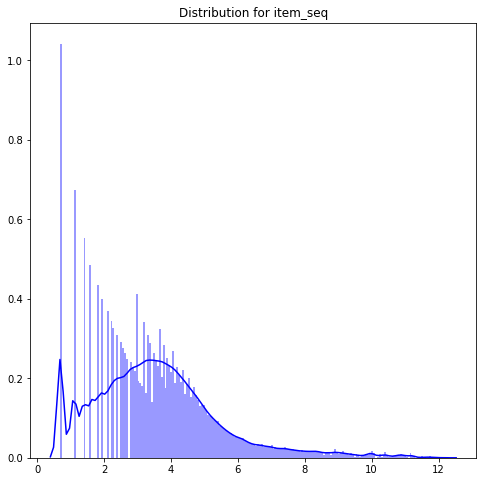

In [35]:
plt.figure(figsize = (8, 8))
plt.title('Distribution for item_seq')
#sns.distplot(df_y_train ,color='green', kde=True,bins=200)
_itemseq = np.log1p(df_x_train['item_seq_number'].dropna().values)
sns.distplot(_itemseq ,color='blue', kde=True,bins=200)
#sns.distplot(df_x_train['avg_days_up_user'] ,color='red', kde=True,bins=200)

plt.show()

In [36]:
cat = df_train['parent_category_name'][1]
cat

'–î–ª—è –¥–æ–º–∞ –∏ –¥–∞—á–∏'

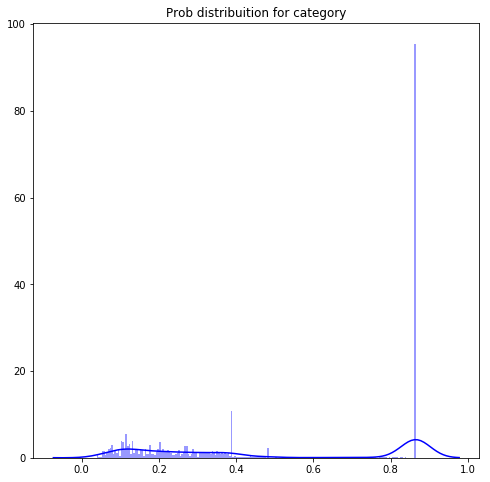

In [37]:
plt.figure(figsize = (8, 8))
plt.title('Prob distribuition for category')
#sns.distplot(df_y_train ,color='green', kde=True,bins=200)
what = df_train[df_train['parent_category_name']==cat]['deal_probability'].replace(0,np.nan).dropna().values
sns.distplot(what ,color='blue', kde=True,bins=200)
#sns.distplot(df_x_train['avg_days_up_user'] ,color='red', kde=True,bins=200)

plt.show()

In [38]:
df_train[df_train['parent_category_name']==cat]['deal_probability'].replace(0,np.nan).dropna().shape

(65913,)

In [39]:
df_train[df_train['parent_category_name']==cat]['deal_probability'].replace(0,np.nan).dropna().unique().shape

(2441,)

In [40]:
df_train_active = pd.read_csv(f'{PATH}/train_active.csv')
df_train_active

item_id       user_id                   region  \
0         70d6342079ef  11d4c04d8c51    –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
1         97cf505710e1  d7068c60b2c6      –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
2         6a93a31a945d  755c88999bc7    –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
3         050cade37667  3d7fb2abdbbc             –ë–∞—à–∫–æ—Ä—Ç–æ—Å—Ç–∞–Ω   
4         2935e85aa40b  fc1be1a809d1                –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω   
5         deb7355cbd7e  7fe1e284ccff      –°–∞—Ä–∞—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
6         c301c65863e0  d9b66fb7c34a                 –£–¥–º—É—Ä—Ç–∏—è   
7         4df800b9dbb5  316092fe1dca       –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
8         58eaf7ee876b  e1b372a5db8f       –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π   
9         4b1edf5131ea  d4c280d0fbd9      –ß–µ–ª—è–±–∏–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
10        bf7d35957718  6adce84ed6df      –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
11        1e77cbff6697  919fadbb65c2      –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
12        9c5510e4d899  8cdd88c2ab72    –ù–∏–∂–µ–≥–æ—Ä–æ–¥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
13        026e2c136902  bf1acd92ed81        –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫–∏–π –∫—Ä–∞–π   
14        a0d27c3b99d8  2299a8424894       –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
15        955020d2f399  0830a05f2ad3     –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
16        11404186c180  d0f566c07c05        –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫–∏–π –∫—Ä–∞–π   
17        0b70eb7e4f1a  504767d92abc      –ß–µ–ª—è–±–∏–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
18        23666a5e4ccb  614587f07e21      –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
19        a10a980e5ea3  3a11a82c09b3     –°–≤–µ—Ä–¥–ª–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
20        d883dca8a010  078d79222911       –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π   
21        07e4eabbd7cc  1144573bbf46      –ß–µ–ª—è–±–∏–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
22        4acc872359e8  8db0650e5a00       –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π   
23        f72c5a6ddf0b  7e8ef375e958        –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
24        024563483ad4  022799b297f0        –¢—é–º–µ–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
25        228a5a085690  00e8a8202a58      –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
26        72f4eb3afba0  c503cd7cefe7        –°–∞–º–∞—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
27        ea266b14b679  bff3e2652281     –í–ª–∞–¥–∏–º–∏—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
28        5b54ac1a53e4  0d4518a2d4b8        –ö—Ä–∞—Å–Ω–æ—è—Ä—Å–∫–∏–π –∫—Ä–∞–π   
29        5194f7f83fae  bef75a783e22                –¢–∞—Ç–∞—Ä—Å—Ç–∞–Ω   
...                ...           ...                      ...   
14129791  8a3d77ff4804  e08f624151ba      –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129792  4ef4a5cdf1f1  637f4990991e       –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π   
14129793  b948868b4c0b  ee7dff9df372      –ö–µ–º–µ—Ä–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129794  16838d483ff4  313d9cc889d0       –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π   
14129795  4ed92bf16384  5888321131db      –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129796  ce0440fb4a45  cd6993e01b0b      –í–æ—Ä–æ–Ω–µ–∂—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129797  25caefef7413  8cc833b8367a       –ö—Ä–∞—Å–Ω–æ–¥–∞—Ä—Å–∫–∏–π –∫—Ä–∞–π   
14129798  b18532c161dc  623db2c62581        –¢—é–º–µ–Ω—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129799  daa8745c391b  9548c16d12b2            –ü–µ—Ä–º—Å–∫–∏–π –∫—Ä–∞–π   
14129800  c23bdab3895f  75ea3875e742       –†–æ—Å—Ç–æ–≤—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129801  b19c5d73b6c2  0b3c391f330c            –ü–µ—Ä–º—Å–∫–∏–π –∫—Ä–∞–π   
14129802  5fa6ed6216ec  2950bddfdc06     –û—Ä–µ–Ω–±—É—Ä–≥—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129803  ce00b4a230f7  11812511fa8c             –ë–∞—à–∫–æ—Ä—Ç–æ—Å—Ç–∞–Ω   
14129804  378e2b091416  7e5ee31d4133           –û–º—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129805  91e03ee0f2b2  a53e4d90a454    –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫–∞—è –æ–±–ª–∞—Å—Ç—å   
14129806  cf1c8788200a  a69d7c355992             –ë–∞—à–∫–æ—Ä—Ç–æ—Å—Ç–∞–Ω   
14129807  a05dc4e731ee  ff670808c23a           –ê–ª—Ç–∞–π—Å–∫–∏–π –∫—Ä–∞–π   
14129808  42b7c3209a94  53dadf3a2e37        –°–∞–º–∞—Ä—Å–∫–∞—è 